In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/Users/zhangbowen/Applications/anaconda3/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
Income_train_Set = pd.read_csv('Income-train.csv') # index_col = 0把instance当作索引，否则会另外建立索引
Income_Pred_Set = pd.read_csv('Income-test.csv')

/Users/zhangbowen/Applications/anaconda3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/zhangbowen/Applications/anaconda3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
Income_train_Set.head()

,Instance,Year of Record,Housing Situation,Crime Level in the City of Employement,Work Experience in Current Job [years],Satisfation with employer,Gender,Age,Country,Size of City,Profession,University Degree,Wears Glasses,Hair Color,Body Height [cm],Yearly Income in addition to Salary (e.g. Rental Income),Total Yearly Income [EUR]
0,1,1940.0,0,33,17,Unhappy,other,45,Afghanistan,25179,group head,No,1,Black,182,0 EUR,6182.05
1,2,1940.0,0,25,4.9,Unhappy,female,17,Afghanistan,2278204,heavy vehicle and mobile equipment service tec...,No,0,Blond,172,0 EUR,6819.69
2,3,1940.0,0,34,21,Unhappy,female,48,Afghanistan,822134,sorter,Bachelor,0,Blond,144,0 EUR,8663.53
3,4,1940.0,0,70,18,Average,female,42,Albania,59477,quality control senior engineer,No,1,Brown,152,0 EUR,2400.64
4,5,1940.0,0,51,8,Happy,other,15,Albania,23494,logistician,Master,1,Black,180,0 EUR,2816.18


In [4]:
_new_column = {'Year of Record':'Year',
               'Housing Situation':'Housing',
               'Crime Level in the City of Employement':'Crime',
               'Work Experience in Current Job [years]':'Experience',
               'Satisfation with employer':'Satisfaction',
               'Size of City':'City',
               'University Degree':'Degree',
               'Wears Glasses':'Glasses',
               'Hair Color':'Hair',
               'Body Height [cm]':'Height',
               'Yearly Income in addition to Salary (e.g. Rental Income)':'Add_Income',
               'Total Yearly Income [EUR]': 'Income'}
Income_train_Set = Income_train_Set.rename(_new_column, axis = 1)
Income_Pred_Set = Income_Pred_Set.rename(_new_column, axis = 1)

In [5]:
Income_train_Set.head()
Income_Pred_Set.head()

,Instance,Year,Housing,Crime,Experience,Satisfaction,Gender,Age,Country,City,Profession,Degree,Glasses,Hair,Height,Add_Income,Income
0,1,1994.0,Small House,23,12,Average,other,23,Serbia,734369,quality assurance specialist,Bachelor,0,Brown,151,0 EUR,NaN
1,2,1964.0,Castle,16,20,Average,NaN,44,Austria,897352,student data analyst,Master,0,Black,181,0 EUR,NaN
2,3,1974.0,Large House,22,11,Average,NaN,21,Serbia,766,project manager,Bachelor,0,Blond,179,0 EUR,NaN
3,4,1997.0,Large Apartment,41,14,Average,male,24,Sierra Leone,1150488,staff engineer / architect,Bachelor,0,Blond,201,0 EUR,NaN
4,5,1949.0,0,22,17,Happy,male,42,Ecuador,98532,machinist,No,1,Blond,163,0 EUR,NaN


In [6]:
#remove EUR in Income column
Income_train_Set['Add_Income'] = Income_train_Set['Add_Income'].map(lambda x : x.replace('EUR', ''))
Income_Pred_Set['Add_Income'] = Income_Pred_Set['Add_Income'].map(lambda x : x.replace('EUR', ''))

In [7]:
#convert Object to float
Income_train_Set['Add_Income'] = pd.to_numeric(Income_train_Set['Add_Income'])
Income_Pred_Set['Add_Income'] = pd.to_numeric(Income_Pred_Set['Add_Income'])

In [8]:
Income_Pred_Set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369438 entries, 0 to 369437
Data columns (total 17 columns):
Instance        369438 non-null int64
Year            367944 non-null float64
Housing         369438 non-null object
Crime           369438 non-null int64
Experience      369438 non-null object
Satisfaction    356006 non-null object
Gender          343130 non-null object
Age             369438 non-null int64
Country         369437 non-null object
City            369438 non-null int64
Profession      368397 non-null object
Degree          340700 non-null object
Glasses         369438 non-null int64
Hair            344787 non-null object
Height          369438 non-null int64
Add_Income      369438 non-null float64
Income          0 non-null float64
dtypes: float64(3), int64(6), object(8)
memory usage: 47.9+ MB


In [11]:
Income_train_Set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 17 columns):
Instance        1048574 non-null int64
Year            1044561 non-null float64
Housing         1048574 non-null object
Crime           1048574 non-null int64
Experience      1048574 non-null object
Satisfaction    1010487 non-null object
Gender          974447 non-null object
Age             1048574 non-null int64
Country         1048574 non-null object
City            1048574 non-null int64
Profession      1045721 non-null object
Degree          967974 non-null object
Glasses         1048574 non-null int64
Hair            978363 non-null object
Height          1048574 non-null int64
Add_Income      1048574 non-null float64
Income          1048574 non-null float64
dtypes: float64(3), int64(6), object(8)
memory usage: 136.0+ MB


In [12]:
def subset_by_iqr(df, column, whisker_width=1.1):
    # Calculate Q1, Q2 and IQR
    q1 = df[column].quantile(0.25)                 
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    # Apply filter with respect to IQR, including optional whiskers
    filter = (df[column] >= q1 - whisker_width*iqr) & (df[column] <= q3 + whisker_width*iqr)
    return df.loc[filter]                  

In [13]:
Income_train_Set = subset_by_iqr(Income_train_Set, 'Income',whisker_width = 1.5)

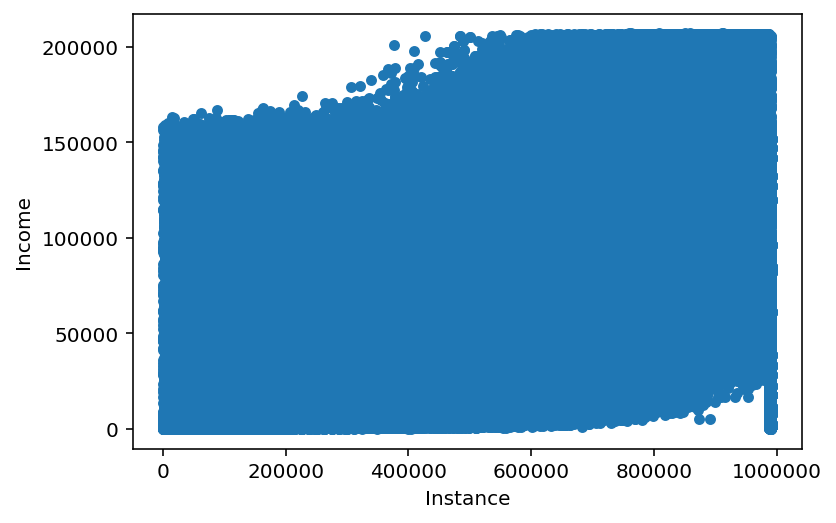

In [14]:
Income_train_Set.plot.scatter(x = 'Instance', y = 'Income')

In [17]:
Concat_Set = pd.concat([Income_train_Set,Income_Pred_Set],ignore_index=True)

In [18]:
from sklearn.impute import SimpleImputer
# fill nan strategy: most_frequent value

"\nYear = Income_train_Set['Hair'].value_counts()   #median();mean();value_counts\nYear\nmost_frequent:\n    *Gender:male\n    *Degree:Bachelor\n    *Hair:Black\n    *country:Honduras\n"

In [20]:
fillna_mode = SimpleImputer(strategy = "most_frequent" ) #fill nan with most frequent

In [21]:
Year = Concat_Set['Year'].values.reshape(-1,1)
Concat_Set['Year'] = fillna_mode.fit_transform(Year)

In [22]:
fillna_dict = {'Satisfaction':'Average',
               'Gender':'female',
               'Country': 'Honduras',
               'Profession': 'payment analyst',
               'Degree': 'Bachelor',
               'Hair': 'Brown'
               }

In [23]:
for key in fillna_dict.keys():
    Concat_Set[key] = Concat_Set[key].fillna(fillna_dict[key])
# using sklearn module get longer runtime

In [24]:
Concat_Set.isnull().sum()

Instance             0
Year                 0
Housing              0
Crime                0
Experience           0
Satisfaction         0
Gender               0
Age                  0
Country              0
City                 0
Profession           0
Degree               0
Glasses              0
Hair                 0
Height               0
Add_Income           0
Income          369438
dtype: int64

In [25]:
def create_cat_con(df,cats,cons,normalize=True):
    for i,cat in enumerate(cats):
        vc = df[cat].value_counts(dropna=False, normalize=normalize).to_dict() #normalize = true 显示不同value占比
        nm = cat + '_FE_FULL' 
        df[nm] = df[cat].map(vc) 
        df[nm] = df[nm].astype('float32')
        for j,con in enumerate(cons):
            new_col = cat +'_'+ con
            print('timeblock frequency encoding:', new_col)
            df[new_col] = df[cat].astype(str)+'_'+df[con].astype(str)  
            temp_df = df[new_col]
            fq_encode = temp_df.value_counts(normalize=True).to_dict()
            df[new_col] = df[new_col].map(fq_encode)
            df[new_col] = df[new_col]/df[cat+'_FE_FULL']
    return df

In [26]:
cats = ['Year', 'Housing', 'Experience',
        'Satisfaction', 'Gender', 'Age',
        'Country', 'Profession', 'Degree', 'Glasses', 'Hair','Crime']
cons = ['City', 'Height', 'Add_Income']

data = create_cat_con(Concat_Set,cats,cons)
'done'

timeblock frequency encoding: Year_City
timeblock frequency encoding: Year_Height
timeblock frequency encoding: Year_Add_Income
timeblock frequency encoding: Housing_City
timeblock frequency encoding: Housing_Height
timeblock frequency encoding: Housing_Add_Income
timeblock frequency encoding: Experience_City
timeblock frequency encoding: Experience_Height
timeblock frequency encoding: Experience_Add_Income
timeblock frequency encoding: Satisfaction_City
timeblock frequency encoding: Satisfaction_Height
timeblock frequency encoding: Satisfaction_Add_Income
timeblock frequency encoding: Gender_City
timeblock frequency encoding: Gender_Height
timeblock frequency encoding: Gender_Add_Income
timeblock frequency encoding: Age_City
timeblock frequency encoding: Age_Height
timeblock frequency encoding: Age_Add_Income
timeblock frequency encoding: Country_City
timeblock frequency encoding: Country_Height
timeblock frequency encoding: Country_Add_Income
timeblock frequency encoding: Profession_

'done'

In [28]:
for col in Income_train_Set.dtypes[Income_train_Set.dtypes == 'object'].index.tolist():
    feat_le = LabelEncoder()
    feat_le.fit(Concat_Set[col].unique().astype(str))
    Concat_Set[col] = feat_le.transform(data[col].astype(str))
    
del_col = set(['Income','Instance'])
features_col =  list(set(Concat_Set) - del_col)

In [29]:
X_train,X_test = Concat_Set[features_col].iloc[:955130],data[features_col].iloc[955131:]
Y_train = data['Income'].iloc[:955130]
X_test_id = data['Instance'].iloc[955131:]
x_train,x_val,y_train,y_val = train_test_split(X_train,Y_train,test_size=0.2,random_state=1234)

In [30]:
params = {
          'max_depth': 20,
          'learning_rate': 0.1,
          "boosting": "gbdt",
          "bagging_seed": 11,
          "metric": 'mse',
          "verbosity": -1,
         }
trn_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val)
# test_data = lgb.Dataset(X_test)
clf = lgb.train(params, trn_data, 100000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
pre_test_lgb = clf.predict(X_test)
'done'

Training until validation scores don't improve for 500 rounds.
[1000]	training's l2: 7.20074e+07	valid_1's l2: 9.11995e+07
[2000]	training's l2: 5.7625e+07	valid_1's l2: 9.0178e+07
Early stopping, best iteration is:
[2183]	training's l2: 5.56705e+07	valid_1's l2: 9.01282e+07


'done'

In [31]:
from sklearn.metrics import mean_squared_error
pre_val_lgb = clf.predict(x_val)
val_mse = mean_squared_error(y_val,pre_val_lgb)
val_rmse = np.sqrt(val_mse)
val_rmse

9493.586132217948

In [37]:
#sub_df.to_csv("sub.csv",index=False)
'done'

'done'